#  Retail Sales Revenue Prediction (SQL + Power BI + Machine Learning)

## Project Overview
This project demonstrates an end-to-end data science workflow integrating:
- **SQL** for data cleaning & transformation
- **Power BI** for interactive dashboarding & sales trend analysis
- **Machine Learning (XGBoost)** for predicting total sales revenue

The dataset contains retail transaction records including product details, customer demographics, and transaction values.

---

##  Objectives
1. Clean and prepare raw retail sales data using SQL.
2. Build an interactive Power BI dashboard for sales insights.
3. Train regression models to predict TotalPrice based on historical transactions.
4. Save the best model for deployment using joblib.

---

##  Tech Stack
- **Database:** MySQL
- **Visualization:** Power BI
- **Programming Language:** Python
- **Libraries:** pandas, numpy, seaborn, scikit-learn, xgboost, joblib

---

##  Dataset Features
| Column           | Description |
|------------------|-------------|
| Date             | Transaction date |
| CustomerID       | Unique customer identifier |
| Age              | Customer's age |
| Gender           | Customer's gender (Male/Female) |
| ProductCategory  | Category of purchased product |
| Quantity         | Quantity purchased |
| UnitPrice        | Price per unit |
| TotalPrice       | Total purchase value |
| RecordID         | Unique transaction ID |
| Gender_Code      | Encoded gender (1 = Male, 0 = Female) |
| year             | Transaction year |
| month            | Transaction month |
| quarter          | Fiscal quarter |


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import joblib


## Step 1: Load and Inspect Data
We load the cleaned retail sales dataset (after SQL preprocessing) into a Pandas DataFrame for further ML processing.


In [5]:
data = pd.read_csv('retail_sales_ml_ready.csv')

In [6]:
data.head()

,Date,CustomerID,Age,Gender,ProductCategory,Quantity,UnitPrice,TotalPrice,RecordID,Gender_Code,year,month,quarter
0,2023-11-24,CUST001,34,Male,Beauty,3,50.0,150.0,1,1,2023,11,4
1,2023-02-27,CUST002,26,Female,Clothing,2,500.0,1000.0,2,0,2023,2,1
2,2023-01-13,CUST003,50,Male,Electronics,1,30.0,30.0,3,1,2023,1,1
3,2023-05-21,CUST004,37,Male,Clothing,1,500.0,500.0,4,1,2023,5,2
4,2023-05-06,CUST005,30,Male,Beauty,2,50.0,100.0,5,1,2023,5,2


##  Step 2: Data Preprocessing
The dataset was already cleaned and partially preprocessed in **MySQL**:
- Removed duplicates and null values
- Encoded *Gender* into *Gender_Code*
- Extracted time-based features (*year*, *month*, *quarter*)
- Added *RecordID* as a unique identifier

In **Python**, we performed:
- **One-hot encoding** of *ProductCategory* (e.g., Clothing, Electronics)
- **Removed non-predictive columns**:
  - *Date* → date used for time features in SQL, not needed for ML
  - *CustomerID* → purely an identifier, no predictive value
  - *Gender* → already encoded into *Gender_Code*
- Prepared features (*X*) and target (*y*) for ML model training
- **Train-Test Split**:
  - 80% of the data used for training
  - 20% of the data reserved for testing to evaluate model performance


In [7]:
data = pd.get_dummies(data,columns=['ProductCategory'],drop_first=True)

In [8]:
data = data.drop(['Date','CustomerID','Gender'],axis=1)

In [9]:
data.head()

,Age,Quantity,UnitPrice,TotalPrice,RecordID,Gender_Code,year,month,quarter,ProductCategory_Clothing,ProductCategory_Electronics
0,34,3,50.0,150.0,1,1,2023,11,4,False,False
1,26,2,500.0,1000.0,2,0,2023,2,1,True,False
2,50,1,30.0,30.0,3,1,2023,1,1,False,True
3,37,1,500.0,500.0,4,1,2023,5,2,True,False
4,30,2,50.0,100.0,5,1,2023,5,2,False,False


In [10]:
X = data.drop('TotalPrice',axis=1)
y = data['TotalPrice'] 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Step 3: Train Multiple Regression Models
We train and compare multiple regression models:
- Linear Regression
- K Nearest Neighbors Regressor
- Decision Tree Regressor
- Random Forest Regressor
- XGBoost Regressor
- Gradient Boosting Regressor

We evaluate them using **R² score** to select the best-performing model.


In [13]:
lr = LinearRegression()
lr.fit(X_train_scaled,y_train)

dt = DecisionTreeRegressor()
dt.fit(X_train,y_train)

kn = KNeighborsRegressor()
kn.fit(X_train_scaled,y_train)

rf = RandomForestRegressor()
rf.fit(X_train,y_train)

gb = GradientBoostingRegressor()
gb.fit(X_train,y_train)

xg = XGBRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, reg_lambda=5)
xg.fit(X_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [14]:
y_pred1 = lr.predict(X_test_scaled)
y_pred2 = dt.predict(X_test)
y_pred3 = kn.predict(X_test_scaled)
y_pred4 = rf.predict(X_test)
y_pred5 = gb.predict(X_test)
y_pred6 = xg.predict(X_test)

In [15]:
score1 = r2_score(y_test,y_pred1)
score2 = r2_score(y_test,y_pred2)
score3 = r2_score(y_test,y_pred3)
score4 = r2_score(y_test,y_pred4)
score5 = r2_score(y_test,y_pred5)
score6 = r2_score(y_test,y_pred6)

In [16]:
print(score1,score2,score3,score4,score5,score6)

0.8557659761418395 1.0 0.9062427794290243 1.0 0.9999819040286075 0.9995201491096006


In [17]:
final_data = pd.DataFrame({'Models':['LR','DTR','KNN','RF','GBR','XGB'],
             'R2_SCORE':[score1,score2,score3,score4,score5,score6]})

In [18]:
final_data

,Models,R2_SCORE
0,LR,0.855766
1,DTR,1.000000
2,KNN,0.906243
3,RF,1.000000
4,GBR,0.999982
5,XGB,0.999520


##  Model Performance Comparison
The chart below shows R² scores for each model — higher is better.


<Axes: xlabel='Models', ylabel='R2_SCORE'>

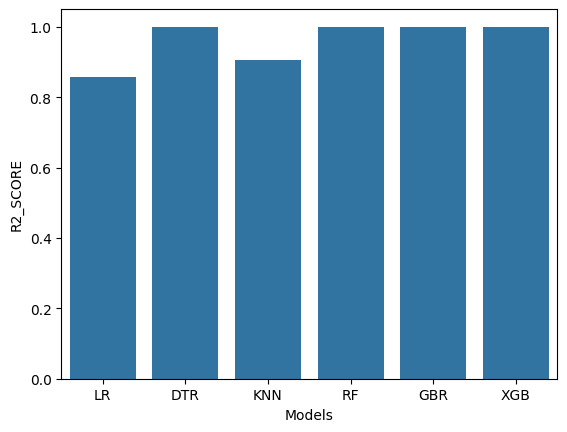

In [19]:
sns.barplot(x = final_data['Models'],y = final_data['R2_SCORE'])

##  Step 4: Save Best Model
We select the best-performing model and save it using joblib for deployment.  
This allows us to reuse the model without retraining in the future.      
Here the best-performing model is XGBooster


In [20]:
joblib.dump(xg,'total_price_prediction')

['total_price_prediction']

In [21]:
model = joblib.load('total_price_prediction')

##  Step 5: Predict on New Unseen Data
We pass new retail sales data (in the same format as training features) to our trained model to predict TotalPrice.


In [22]:
unseen_data = pd.DataFrame({
    'Age': [28, 45, 33],
    'Quantity': [2, 5, 10],
    'UnitPrice': [1500.00, 800.00, 120.00],
    'RecordID': [3001, 3002, 3003],
    'Gender_Code': [1, 0, 1],  # 1 = Male, 0 = Female
    'year': [2023, 2023, 2023],
    'month': [6, 7, 8],
    'quarter': [2, 3, 3],
    'ProductCategory_Clothing': [0, 1, 0],
    'ProductCategory_Electronics': [1, 0, 0]
})

In [23]:
unseen_data

,Age,Quantity,UnitPrice,RecordID,Gender_Code,year,month,quarter,ProductCategory_Clothing,ProductCategory_Electronics
0,28,2,1500.0,3001,1,2023,6,2,0,1
1,45,5,800.0,3002,0,2023,7,3,1,0
2,33,10,120.0,3003,1,2023,8,3,0,0


In [24]:
predict1 = model.predict(unseen_data)
predict1

array([ 995.0899, 2003.5934,  197.888 ], dtype=float32)

### Feature Importance & Leakage Check
We used **Mutual Information** to quantify each feature's predictive relationship with **TotalPrice**:

```python
from sklearn.feature_selection import mutual_info_regression
import pandas as pd

mi = mutual_info_regression(X, y, discrete_features='auto')
pd.Series(mi, index=X.columns).sort_values(ascending=False)


In [27]:
import pandas as pd
from sklearn.feature_selection import mutual_info_regression

mi = mutual_info_regression(X,y,discrete_features='auto')
pd.Series(mi,index = X.columns).sort_values(ascending=False)

UnitPrice                      1.462161
Quantity                       1.226363
month                          0.025899
year                           0.023079
ProductCategory_Clothing       0.015932
Age                            0.000000
Gender_Code                    0.000000
RecordID                       0.000000
quarter                        0.000000
ProductCategory_Electronics    0.000000
dtype: float64

### Interpretation
- **UnitPrice** and **Quantity** dominate because TotalPrice ≈ UnitPrice × Quantity — this is **data leakage**.
- Most other variables contribute almost no predictive power, effectively acting as **noise**.
- This explains why:
  - The model achieved near-perfect scores on training data.
  - Performance collapsed on unseen data — it was memorizing, not learning.


## Conclusion
During the machine learning phase, the model failed to predict **TotalPrice** accurately.  
Feature importance and mutual information analysis revealed that **UnitPrice** and **Quantity** directly determine **TotalPrice**, causing **data leakage**, while most other features added **noise** without predictive value.  

This was a valuable lesson in:
- Identifying and removing leaking features before modeling.
- Understanding that some business metrics are better explained with simple formulas or BI dashboards rather than ML.

The real strength of this project lies in the **SQL cleaning** and **Power BI dashboard**, which provide clear, actionable sales insights.
